In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

df = pd.read_parquet('workforce-summary.parquet')
df['qrt'] = pd.qcut(df['total_monthly_ce'], 4, labels=['1st', '2nd', '3rd', '4th'])
df.head()

sector  gender  age  \
fsu_serial_no sample_hh_no person_serial_no                       
30010         1            1                 Rural    male   45   
              2            3                 Rural  female   29   
              3            1                 Rural    male   48   
                           2                 Rural  female   44   
              4            1                 Rural    male   38   

                                                marital_status      education  \
fsu_serial_no sample_hh_no person_serial_no                                     
30010         1            1                     never married       graduate   
              2            3                 currently married       graduate   
              3            1                 currently married      secondary   
                           2                 currently married  below primary   
              4            1                 currently married        primary   

                                             nic_2008_principal_activity  \
fsu_serial_no sample_hh_no person_serial_no                                
30010         1            1                                        85.0   
              2            3                                        86.0   
              3            1                                         1.0   
                           2                                         NaN   
              4            1                                        49.0   

                                               mult  religion  \
fsu_serial_no sample_hh_no person_serial_no                     
30010         1            1                 208857  Hinduism   
              2            3                 208857  Hinduism   
              3            1                 208857  Hinduism   
                           2                 208857  Hinduism   
              4            1                 208857  Hinduism   

                                                     social_group  \
fsu_serial_no sample_hh_no person_serial_no                         
30010         1            1                 other backward class   
              2            3                 other backward class   
              3            1                 other backward class   
                           2                 other backward class   
              4            1                 other backward class   

                                             total_monthly_ce  ...  ACT_1  \
fsu_serial_no sample_hh_no person_serial_no                    ...          
30010         1            1                           7142.0  ...  300.0   
              2            3                          18317.0  ...  480.0   
              3            1                          10147.0  ...  480.0   
                           2                          10147.0  ...   30.0   
              4            1                          13387.0  ...  570.0   

                                            ACT_2  ACT_3 ACT_4 ACT_5 ACT_6  \
fsu_serial_no sample_hh_no person_serial_no                                  
30010         1            1                 30.0  300.0   0.0   0.0   0.0   
              2            3                  0.0  180.0  60.0   0.0   0.0   
              3            1                  0.0    0.0   0.0   0.0   0.0   
                           2                 60.0  630.0   0.0   0.0   0.0   
              4            1                  0.0    0.0   0.0   0.0   0.0   

                                             ACT_7  ACT_8  ACT_9  qrt  
fsu_serial_no sample_hh_no person_serial_no                            
30010         1            1                  60.0  120.0  720.0  1st  
              2            3                 120.0    0.0  750.0  4th  
              3            1                 180.0  150.0  720.0  2nd  
                           2                 150.0   90.0  810.0  2nd  
              

In [2]:
df['age-group'] = pd.cut(df['age'], [10, 20, 30, 40, 50, 60], labels=['<= 20', '20-30', '30-40', '40-50', '50-60'])
# df['age']

Text(0.5, 0.95, 'The average Indian worker puts in 40 to 60 hours a week\n(Source: Time Use Survey 2024)')

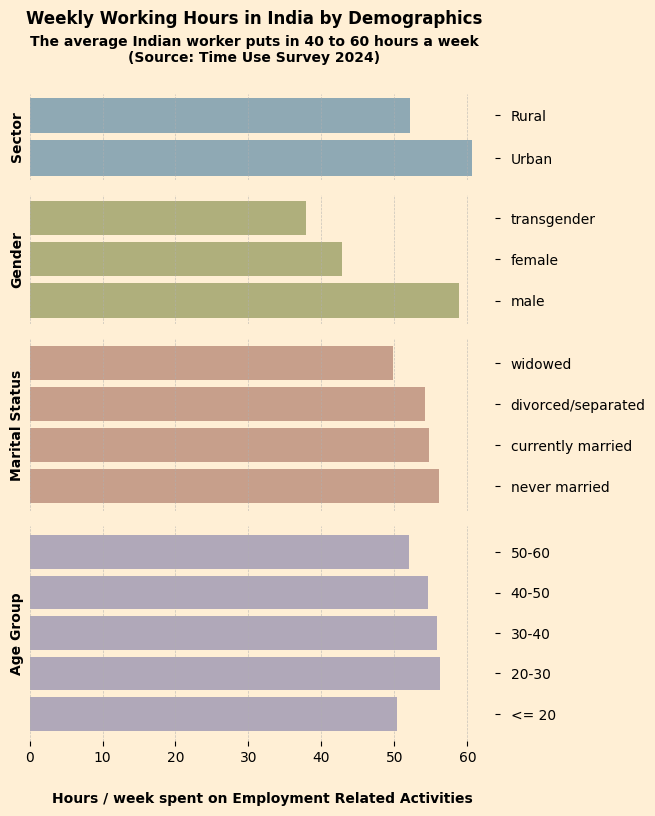

In [5]:
CAT_COLS = ['sector', 'gender', 'marital_status', 'age-group']
data = {}

for c in CAT_COLS:
    t = df.groupby(c).apply(lambda x: (x['ACT_1'] * x['mult']).sum() / x['mult'].sum())
    t = t / 60 * 7
    if c == 'age-group':
        data[c] = t[['<= 20', '20-30', '30-40', '40-50', '50-60']]
    else:
        data[c] = t.sort_values(ascending=False)

colors = [
    "#8FA9B4",  # muted blue-gray
    "#AFAF7C",  # soft olive
    "#C79F8B",  # dusty peach
    "#B0A8B9",  # muted lavender-gray
    "#9EB5A1",  # soft sage green
    "#D1B3A1",  # pale rose-beige
]

bar_height = 0.5      # thickness of each bar
bar_spacing = 0.6     # center-to-center distance between bars (1 = default, <1 = closer)

heights = [len(s) * bar_spacing for s in data.values()]

fig = plt.figure(figsize=(6, sum(heights)), facecolor="papayawhip")
gs = gridspec.GridSpec(len(data), 1, height_ratios=heights, hspace=0.1)

axes = []
for i, (title, series) in enumerate(data.items()):
    ax = fig.add_subplot(gs[i], sharex=axes[0] if axes else None, facecolor="papayawhip")
    
    # Space bars according to bar_spacing
    y = [j * bar_spacing for j in range(len(series))]
    ax.barh(y, series.values, height=bar_height, color=colors[i % len(colors)])
    ax.set_yticks(y)
    ax.set_yticklabels(series.index)
    # ax.yaxis.set_label_position('right')
    
    # Extra padding for tick-label gap
    ax.tick_params(axis="y", pad=8)
    ax.yaxis.tick_right()

    # Bold axis label (group name)
    ax.set_ylabel(title.replace('_', ' ').replace('-', ' ').title(), fontweight="bold")

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Vertical gridlines
    ax.xaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

    # Hide x-axis ticks except bottom
    if i != len(data) - 1:
        ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    else:
        ax.set_xlabel('Hours / week spent on Employment Related Activities', labelpad=20, fontweight='bold')


    axes.append(ax)
fig.suptitle('Weekly Working Hours in India by Demographics', fontweight='bold', fontsize='large', y=0.98)
fig.text(0.5, 0.95, 'The average Indian worker puts in 40 to 60 hours a week\n(Source: Time Use Survey 2024)', ha='center', va='top', fontweight="bold")

In [6]:
df.groupby(['gender', 'sector']).apply(lambda x: (x['ACT_1'] * x['mult']).sum() / x['mult'].sum()).unstack() * 7 / 60

sector,Rural,Urban
gender,,
female,40.487140,49.076974
male,56.363324,63.907593
transgender,38.459366,35.282156


In [7]:
# Split the workforce into whitecollar vs non-whitecollar jobs
import yaml
with open('nic-white-collar.yaml', 'r') as fin:
    WC_NIC = yaml.safe_load(fin).keys()
    
whitecollar = df[df['nic_2008_principal_activity'].isin(WC_NIC)]
df.drop(whitecollar.index, axis=0, inplace=True)

In [8]:
ACT_COLS = [f'ACT_{i}' for i in range(1, 10)]
workforce_ts = df.groupby('gender').apply(lambda x: pd.Series((x[ACT_COLS].values * x['mult'].values.reshape(-1, 1)).sum(axis=0) / x['mult'].sum()))
workforce_ts.columns = ACT_COLS
workforce_ts *= 7 / 60
workforce_ts = workforce_ts.loc[['female', 'male']]


wc_ts = whitecollar.groupby('gender').apply(lambda x: pd.Series((x[ACT_COLS].values * x['mult'].values.reshape(-1, 1)).sum(axis=0) / x['mult'].sum()))
wc_ts.columns = ACT_COLS
wc_ts *= 7 / 60
wc_ts = wc_ts.loc[['female', 'male']]


In [13]:
wfts = workforce_ts.unstack().reset_index()
wfts.columns = ['activity', 'gender', 'time_spent']
wfts['type'] = 'workforce'

In [16]:
wcts = wc_ts.unstack().reset_index()
wcts.columns = ['activity', 'gender', 'time_spent']
wcts['type'] = 'whitecollar'

In [18]:
worktime = pd.concat([wcts, wfts], axis=0)
worktime.sample(10)

,activity,gender,time_spent,type
16,ACT_9,female,81.854336,whitecollar
15,ACT_8,male,17.790561,workforce
8,ACT_5,female,0.100376,workforce
16,ACT_9,female,82.482155,workforce
10,ACT_6,female,0.276222,whitecollar
6,ACT_4,female,3.278013,whitecollar
8,ACT_5,female,0.104870,whitecollar
2,ACT_2,female,0.403869,whitecollar
6,ACT_4,female,4.640436,workforce
1,ACT_1,male,62.019382,whitecollar


In [19]:
data_to_plot = worktime[~worktime['activity'].isin(['ACT_9', 'ACT_2', 'ACT_5', 'ACT_6'])]

In [21]:
labels = {
    "ACT_1": "Employment / Paid Work",
    "ACT_3": "Unpaid Domestic Services for Family",
    "ACT_4": "Unpaid Caregiving for Family",
    "ACT_7": "Socializing / Religious Practice / Community",
    "ACT_8": "Culture / Leisure / Mass-media / Sports",
}

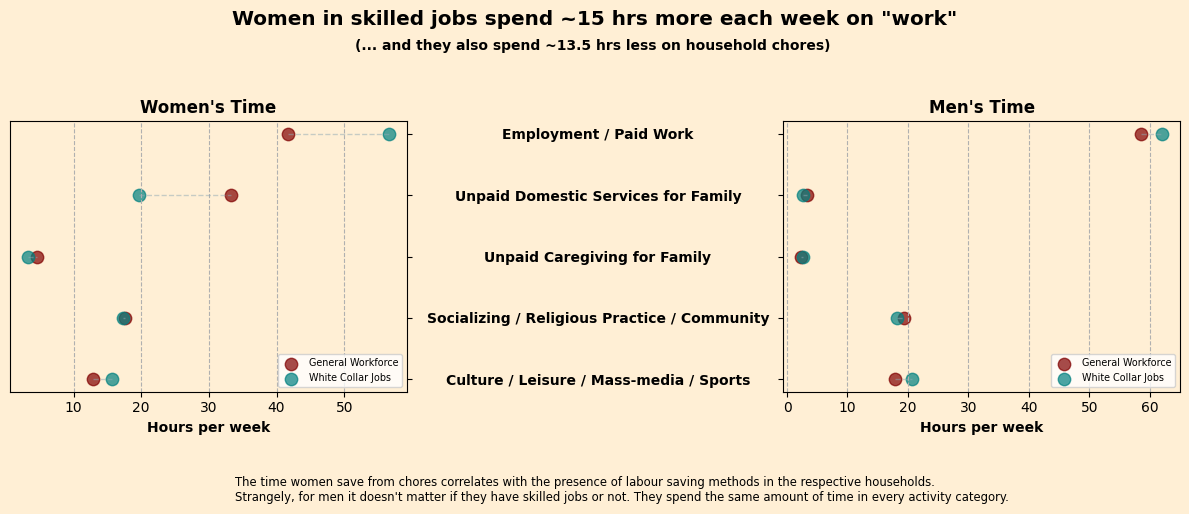

In [105]:
fig, (ax_women, ax_men) = plt.subplots(nrows=1, ncols=2, facecolor='papayawhip', figsize=(12, 4))
ax_women.set_facecolor('papayawhip')
ax_men.set_facecolor('papayawhip')

# sns.barplot(xx.unstack().reset_index(), x=0, y="level_0", hue="gender", ax=ax_wf, palette=['teal', 'maroon'], alpha=0.5,
#             order=ORDER)
# sns.barplot(yy.unstack().reset_index(), x=0, y="level_0", hue="gender", ax=ax_wc, palette=['teal', 'maroon'], alpha=0.5,
#             order=ORDER)
women_general = worktime[worktime['gender'] == 'female']
women_general_time = women_general[women_general['type'] == 'workforce'].set_index('activity').loc[labels.keys()]['time_spent']
women_skilled_time = women_general[women_general['type'] == 'whitecollar'].set_index('activity').loc[labels.keys()]['time_spent']
ax_women.scatter(women_general_time, range(len(labels)), s=80, alpha=0.7, color='maroon', label='General Workforce')
ax_women.scatter(women_skilled_time, range(len(labels)), s=80, alpha=0.7, color='teal', label="White Collar Jobs")
ax_women.hlines(range(len(labels)),
                [min(a, b) for a, b in zip(women_general_time, women_skilled_time)],
                [max(a, b) for a, b in zip(women_general_time, women_skilled_time)],
               linestyle='dashed', lw=1, color="#8FA9B4", alpha=0.5)
men_general = worktime[worktime['gender'] == 'male']
men_general_time = men_general[men_general['type'] == 'workforce'].set_index('activity').loc[labels.keys()]['time_spent']
men_skilled_time = men_general[men_general['type'] == 'whitecollar'].set_index('activity').loc[labels.keys()]['time_spent']
ax_men.scatter(men_general_time, range(len(labels)), s=80, alpha=0.7, color='maroon', label="General Workforce")
ax_men.scatter(men_skilled_time, range(len(labels)), s=80, alpha=0.7, color='teal', label="White Collar Jobs")
ax_men.hlines(range(len(labels)),
                [min(a, b) for a, b in zip(men_general_time, men_skilled_time)],
                [max(a, b) for a, b in zip(men_general_time, men_skilled_time)],
               linestyle='dashed', lw=1, color='#8FA9B4', alpha=0.5)


ax_men.set_yticks(range(len(labels)), labels.values(), ha="center", fontweight="bold")
ax_men.tick_params(axis="y", pad=130)
ax_men.yaxis.tick_left()
ax_women.yaxis.tick_right()
ax_women.set_yticks(range(len(labels)), [])
ax_women.xaxis.grid(linestyle='dashed')
ax_men.xaxis.grid(linestyle='dashed')

ax_men.legend(loc="lower right", fontsize="x-small")
ax_women.legend(loc="lower right", fontsize="x-small")

ax_men.invert_yaxis()
ax_women.invert_yaxis()

ax_women.set_xlabel('Hours per week', fontweight="bold")
ax_men.set_xlabel('Hours per week', fontweight="bold")
ax_women.set_title('Women\'s Time', fontweight="bold", fontsize="large")
ax_men.set_title('Men\'s Time', fontweight="bold", fontsize="large")

fig.suptitle('Women in skilled jobs spend ~15 hrs more each week on "work"', fontsize="x-large", fontweight="bold", y=1.1)
fig.text(0.3, 1, "(... and they also spend ~13.5 hrs less on household chores)", fontsize="medium", fontweight="bold")
_ = fig.text(0.2, -0.1,
         ("The time women save from chores correlates with the presence of labour saving methods in the respective households.\n"
          "Strangely, for men it doesn't matter if they have skilled jobs or not. They spend the same amount of time in every activity category."),
         fontsize="small", va="center")
plt.tight_layout()

In [30]:
women_general[women_general['type'] == 'workforce'].set_index('activity').loc[labels.keys()]

,gender,time_spent,type
activity,,,
ACT_1,female,41.727850,workforce
ACT_3,female,33.222547,workforce
ACT_4,female,4.640436,workforce
ACT_7,female,17.644078,workforce
ACT_8,female,12.820892,workforce


In [171]:
# What are some factors that enable women to do less unpaid household work?
META_COLS = ['religion', 'social_group', 'qrt',
             'energy_cooking', 'energy_lighting', 'washing_type', 'sweeping_type',
             'dwelling_unit', 'dwelling_unit_structure_type', 'age-group']

wf_women = df[df['gender'] == 'female']
wc_women = whitecollar[whitecollar['gender'] == 'female']

payload = []
for COL in META_COLS:
    xx = wf_women.groupby(COL).apply(lambda x: x['mult'].sum() / wf_women['mult'].sum()).sort_values()
    yy = wc_women.groupby(COL).apply(lambda x: x['mult'].sum() / wc_women['mult'].sum()).sort_values()
    xx.name, yy.name = "workforce", "white-collar"
    xdf = pd.concat([xx, yy], axis=1)
    print(xdf)


              workforce  white-collar
religion                             
Jainism        0.000939      0.004555
others         0.003331      0.002205
Buddhism       0.007860      0.008395
Sikhism        0.013706      0.014840
Christianity   0.028873      0.063271
Islam          0.079161      0.040036
Hinduism       0.866130      0.866699
                      workforce  white-collar
social_group                                 
scheduled tribe        0.141605      0.050500
others                 0.185937      0.413172
scheduled caste        0.208161      0.160072
other backward class   0.464297      0.376257
     workforce  white-collar
qrt                         
4th   0.202011      0.504215
3rd   0.241195      0.190780
2nd   0.252754      0.167114
1st   0.304040      0.137891
                                                    workforce  white-collar
energy_cooking                                                             
biogas                                               0.0

In [170]:
xdf

,workforce,white-collar
sweeping_type,,
outsourced,0.012809,0.140959
mechanical by hh members,0.018394,0.065074
manual by hh members,0.968797,0.793967


1. Half the women in white collar jobs are in the 4th quartile
2. LPG presence is 90% in WC jobs

### How men rest

In [196]:
df = pd.read_parquet('../../time-use-survey-2024/clean/per-tus-2024.parquet')

men = df[df['gender'] == 'male']
men = men[men['age'] >= 15]
men = men[men['age'] <= 60]

men_rest = men[men['activity_code'].astype(str).str.startswith('9')]

In [203]:
def get_time_spent(time_from, time_to):
    if time_from == time_to:
        return 24 * 60
    start_hour, start_min = map(int, time_from.split(':'))
    end_hour, end_min = map(int, time_to.split(':'))
    minutes = end_hour * 60 + end_min - start_hour * 60 - start_min
    if minutes > 0:
        return minutes
    return 24 * 60 + minutes


men_rest['ts'] = men_rest[['time_from', 'time_to']].apply(lambda x: get_time_spent(**x), axis=1)
men_rest['activity_code'] = men_rest['activity_code'].astype(int).astype(str)
resting_time = men_rest.groupby([men_rest.index, 'activity_code'])['ts'].sum()

/tmp/ipykernel_20306/129871678.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_rest['ts'] = men_rest[['time_from', 'time_to']].apply(lambda x: get_time_spent(**x), axis=1)
/tmp/ipykernel_20306/129871678.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  men_rest['activity_code'] = men_rest['activity_code'].astype(int).astype(str)


In [204]:
resting_time = resting_time.unstack()
resting_time.columns = [f'ACT_{col}' for col in resting_time]
resting_time.index = pd.MultiIndex.from_tuples(resting_time.index, names=df.index.names)

In [206]:
resting_time.fillna(value=0, inplace=True)

In [209]:
mult = men_rest['mult'].reset_index().drop_duplicates().set_index(men_rest.index.names, verify_integrity=True)['mult']

In [210]:
mult

fsu_serial_no  sample_hh_no  person_serial_no
32223          1             1                   67243
               3             2                   67243
               4             1                   67243
               5             1                   67243
                             3                   67243
                                                 ...  
60861          9             1                    2877
                             2                    2877
               10            1                    2877
               13            1                    2877
               14            1                    2877
Name: mult, Length: 170009, dtype: int64

In [224]:
avg_rest = pd.Series((resting_time.values * mult.values.reshape(-1, 1)).sum(axis=0) / mult.sum(), index=resting_time.columns)

In [225]:
avg_rest = avg_rest * 7 / 60

In [226]:
labels = {
    91: "Sleep",
    92: "Eating & Drinking",
    93: "Personal Hygiene and Care",
    94: "Receiving Personal Care",
    95: "Travel for Self-Care",
    99: "Other Self-Care"
}
avg_rest = avg_rest.reset_index()
avg_rest['labels'] = avg_rest['index'].apply(lambda x: labels[int(x.split('_')[-1][:2])])

In [229]:
avg_rest.groupby('labels')[0].sum().to_clipboard()